# Introducing the test models



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score
from collections import Counter

## 4.3 Supervised Learning Approach  
(logistic regression, decision tree, Naive Bayes and K-nearest neighbor)


Multinomial Logistic Regression


In [6]:
# --- ASSUMED INPUT DATA STRUCTURE ---
# X: Feature matrix (N_samples x N_features)
# y: Target labels (N_samples,)
# N_samples: Number of sliding windows (data points)
# N_features: Number of features extracted per window (e.g., Mean, SD, RMS for each of the 9 axes)

# Example: Replace with your actual loaded and engineered data
# X = pd.DataFrame(data=..., columns=feature_names) 
# y = np.array(labels)
# ------------------------------------

# --- STEP 1: LOAD AND PREPARE DATA ---
# This is a placeholder for your feature matrix and labels.
# You must replace this with the actual output from your Feature Engineering step.
# For a runnable example, we create dummy data:
N_SAMPLES = 1000
N_FEATURES = 25
# 5 target activities: Walking, Running, Stairs, Standing, Sitting
ACTIVITIES = ['Walking', 'Running', 'Stairs', 'Sitting', 'Standing'] 
N_CLASSES = len(ACTIVITIES)

# Create dummy feature data (e.g., random data following a standard normal distribution)
np.random.seed(33)
X = np.random.randn(N_SAMPLES, N_FEATURES)

# Create dummy labels (e.g., ensuring a somewhat balanced dataset)
label_repetitions = N_SAMPLES // N_CLASSES
y = np.repeat(ACTIVITIES, label_repetitions)[:N_SAMPLES]
# Shuffle the labels to simulate a real-world mixed dataset
np.random.shuffle(y) 

print(f"Total samples: {len(X)}")
print(f"Feature count: {X.shape[1]}")
print(f"Class distribution: {Counter(y)}")

# --- STEP 2: SPLIT DATA ---
# Split the dataset into training and testing sets (e.g., 70% train, 30% test)
# Use stratification to ensure the activity distribution is maintained in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=33, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- STEP 3: FEATURE SCALING (IMPORTANT FOR LOGISTIC REGRESSION) ---
# Logistic Regression, like many models based on gradient descent, benefits from scaling.
# We fit the scaler ONLY on the training data to prevent data leakage.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 4: TRAIN MULTINOMIAL LOGISTIC REGRESSION MODEL ---

# LogisticRegression is a suitable model for multi-class classification
# when 'multi_class' is set to 'multinomial' (or 'auto', which defaults to 'multinomial'
# if the solver supports it, and 'ovr' otherwise).
# 'solver'='lbfgs' is a good default choice for small to medium datasets and multinomial loss.

# Hyperparameter Choice:
# C (Inverse of regularization strength): A lower C means stronger regularization.
# C=1.0 is a common starting point. You may need to tune this.

mlr_model = LogisticRegression(
    penalty='l2',            # L2 regularization
    C=1.0,                   # Regularization strength
    multi_class='multinomial', # Set for multi-class classification
    solver='lbfgs',          # Optimization algorithm
    max_iter=500,            # Increase if convergence warning appears
    random_state=33,
    n_jobs=-1                # Use all processors for faster training
)

print("\nTraining Multinomial Logistic Regression...")
mlr_model.fit(X_train_scaled, y_train)
print("Training complete.")

# --- STEP 5: PREDICT AND EVALUATE MODEL PERFORMANCE ---

# Make predictions on the test set
y_pred = mlr_model.predict(X_test_scaled)

# [cite_start]Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=ACTIVITIES)

# Display Results
print("\n--- Model Evaluation (Multinomial Logistic Regression) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=ACTIVITIES, columns=ACTIVITIES))

# --- STEP 6: MODEL INTERPRETATION (Feature Weights) ---

# The coefficients (weights) give insight into feature importance.
# Note: For multi-class, there is one set of coefficients per class.
# The absolute magnitude of a coefficient indicates its influence on that specific class.
print("\n--- Feature Importance (Top Weights per Class) ---")

# Placeholder for your actual feature names
feature_names = [f'Feature_{i+1}' for i in range(N_FEATURES)]
coef_df = pd.DataFrame(mlr_model.coef_, columns=feature_names, index=ACTIVITIES)

for activity in ACTIVITIES:
    weights = coef_df.loc[activity].abs().sort_values(ascending=False)
    print(f"Top 5 most influential features for predicting {activity}:")
    print(weights.head(5))

# You should use this interpretation to help answer Research Question 1
# by relating the highest-weighted features to your sensor analysis.

Total samples: 1000
Feature count: 25
Class distribution: Counter({np.str_('Standing'): 200, np.str_('Sitting'): 200, np.str_('Walking'): 200, np.str_('Running'): 200, np.str_('Stairs'): 200})

Training samples: 700
Testing samples: 300

Training Multinomial Logistic Regression...


d:\Masters\Q1\5ARE0_Data_analysis_and_learning_methods\Assignment_1\GitClone\Data-Analysis-Assignment-1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete.

--- Model Evaluation (Multinomial Logistic Regression) ---
Accuracy: 0.1833
F1-Score (Macro): 0.1818
Cohen's Kappa: -0.0208

Confusion Matrix:
          Walking  Running  Stairs  Sitting  Standing
Walking        14        6      16        8        16
Running        14       10       9       16        11
Stairs         17       11      12       12         8
Sitting        16       14      12       12         6
Standing       12       21      10       10         7

--- Feature Importance (Top Weights per Class) ---
Top 5 most influential features for predicting Walking:
Feature_16    0.183087
Feature_12    0.181233
Feature_21    0.139186
Feature_10    0.137203
Feature_14    0.123409
Name: Walking, dtype: float64
Top 5 most influential features for predicting Running:
Feature_19    0.219202
Feature_21    0.208253
Feature_24    0.162814
Feature_13    0.160326
Feature_14    0.126607
Name: Running, dtype: float64
Top 5 most influential features for predicting Stairs:
Feat

## 4.4 Unsupervised Learning Approach  
(hard) k-means, fuzzy C-means and Gaussian mixture models. Make use of PCA
for visualization

### Hard k-means

Total samples (windows): 121
Total features used: 204
Number of clusters (K): 5
----------------------------------------
Variance Explained by PC1: 0.53
Variance Explained by PC2: 0.12
Total Variance Explained: 0.65
----------------------------------------
Adjusted Rand Index (ARI): 0.8522 (0.0=random, 1.0=perfect match)
Normalized Mutual Information (NMI): 0.8617 (0.0=no mutual info, 1.0=perfect match)


C:\Users\alexa\AppData\Local\Temp\ipykernel_7972\959983679.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_clusters))


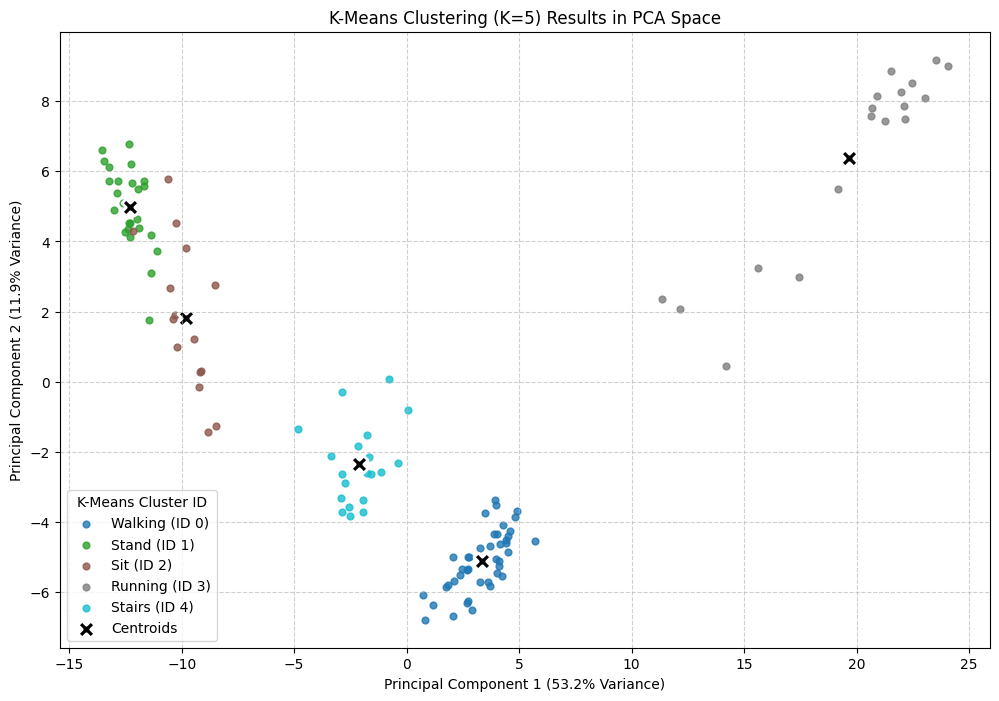

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the data feature matrix and labels ## LATER ON WE CAN REMOVE THE PROMPT AND JUST LOAD THE CSV
try:
    df = pd.read_csv("features.csv")
except FileNotFoundError:
    print("Error: features.csv not found. Please ensure the file is in the current directory.")
    exit()

# Identify Non-Feature columns
Non_feat_columns = ['activity', 'trial', 'student', 'window_idx']

#Drop the non-feature columns so that we only have the features left
X = df.drop(columns=Non_feat_columns, errors='ignore')

# We use the activity column for evaluation later (since, during recordings we have labeled each entry with an activity).We don't use it for clustering since K-Means is unsupervised.
y_true = df['activity'].astype('category')
Nr_clusters = y_true.nunique() # Counts the number of unique activities and assigns it to Nr_clusters

print(f"Total samples (windows): {X.shape[0]}")
print(f"Total features used: {X.shape[1]}")
print(f"Number of clusters (K): {Nr_clusters}")
print("-" * 40)

#Use StandardScaler from sklearn to standardize the features. It centers the data (mean=0) and scales it (std=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Since we are going to visualize the clusters in 2D, we use PCA to reduce the dimensionality of the feature space to 2 principal components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Variance Explained by PC1: {explained_variance[0]:.2f}")
print(f"Variance Explained by PC2: {explained_variance[1]:.2f}")
print(f"Total Variance Explained: {sum(explained_variance):.2f}")
print("-" * 40)

#Create and train the K-Means model
K_means_model = KMeans(
    n_clusters=Nr_clusters,
    init='k-means++', # Smart initialization method
    max_iter=300,
    n_init=10, # Run 10 times with different centroids to find the best result
    random_state=33
)
K_means_model.fit(X_scaled)
cluster_labels = K_means_model.labels_ # Get the cluster assignments (labels)

# Here we assign labels to the cluster IDs based on the majority class within that cluster.
# It helps with interpreting what each cluster represents.
df_labeled_temp = pd.DataFrame({
    'Cluster_ID': cluster_labels,
    'True_Activity': y_true
})

# Create the Contingency Table (Cross-Tabulation)
contingency_table = pd.crosstab(
    df_labeled_temp['Cluster_ID'],
    df_labeled_temp['True_Activity']
)

# Determine the majority activity for each cluster ID
cluster_to_activity_mapping = {}
for cluster_id in contingency_table.index:
    majority_activity = contingency_table.loc[cluster_id].idxmax()
    cluster_to_activity_mapping[cluster_id] = majority_activity

unique_clusters = np.unique(cluster_labels) # Get the unique cluster IDs


#Plotting and Visualization

plt.figure(figsize=(12, 8))
cmap = plt.cm.get_cmap('tab10', len(unique_clusters))

# Iterate through each cluster ID to plot it separately, which allows for a clean legend
for cluster_id in unique_clusters:
    indices = cluster_labels == cluster_id
    activity_name = cluster_to_activity_mapping[cluster_id]

    # Plot the subset of points for this cluster
    plt.scatter(
        X_pca[indices, 0],              # PC1 on the X-axis
        X_pca[indices, 1],              # PC2 on the Y-axis
        c=[cmap(cluster_id)],           # Assign the color from the colormap
        label=f'{activity_name} (ID {cluster_id})',  # Use the Activity Name + ID
        alpha=0.8,
        s=24,
    )

# Centroids must also be transformed to the PCA space for plotting
centroids = K_means_model.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=150,
    linewidths=2,
    color='black',
    edgecolors='white',
    label='Centroids'
)


# Set labels, title, and legend
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.1f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.1f}% Variance)")
plt.title(f"K-Means Clustering (K={Nr_clusters}) Results in PCA Space")
plt.legend(title='K-Means Cluster ID', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)


#Evaluation of the model using the true labels for reference

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(y_true, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)


print(f"Adjusted Rand Index (ARI): {ari:.4f} (0.0=random, 1.0=perfect match)")
print(f"Normalized Mutual Information (NMI): {nmi:.4f} (0.0=no mutual info, 1.0=perfect match)")

### Fuzzy C-means
